In [4]:
import xarray as xr
import numpy as np
import s3fs
from skimage import measure, feature
from sklearn import preprocessing
import matplotlib.pyplot as plt
import echopype as ep

# Download dataset
Download netcdf dataset from imos-data/IMOS/SOOP/SOOP-BA/VLMJ_Investigator/

In [5]:
fname = 'D:/GLIDER2018/Echosounder/Echosounder/nc_files/GLIDER_SB_2018_v5-Phase0-D20180624-T221256-2.nc'
ed = ep.open_converted(fname)
ds = ep.calibrate.compute_Sv(ed, waveform_mode='BB', encode_mode='complex')

<string>:6: DeprecationWarning: `np.alen` is deprecated, use `len` instead


In [6]:
#ds.coords['range_bin']=np.array(ds.range[0,0,:]) # replace range bin with depth value/range

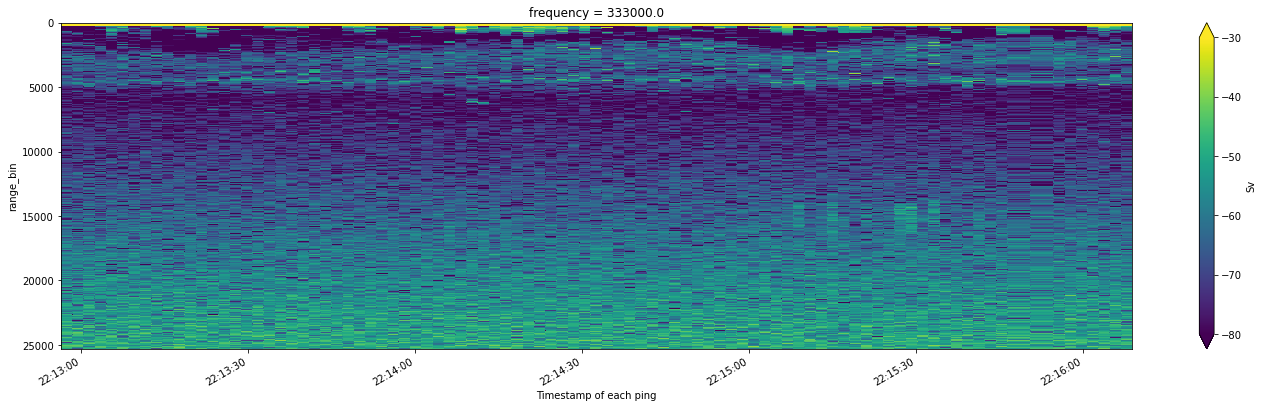

In [7]:
fig = (ds.Sv).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# Get layers of interest

Working on one channel at a time so please select the channel first

In [8]:
ds_s = ds[['Sv']].isel(frequency=0,range_bin=slice(300,10000), ping_time=slice(0,30))
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2018-06-24T22:12:57.422000128 ... 2...
    frequency  float64 3.33e+05
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -17.1 -22.08 ... -72.1 -66.98

## Interpolation along DEPTH axis and drop all nan slices in TIME

In [9]:
ds_s = ds_s.interpolate_na('range_bin', method="linear", fill_value="extrapolate")
ds_s = ds_s.dropna('ping_time')
ds_s

<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-24T22:12:57.422000128 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -17.1 -22.08 ... -72.1 -66.98

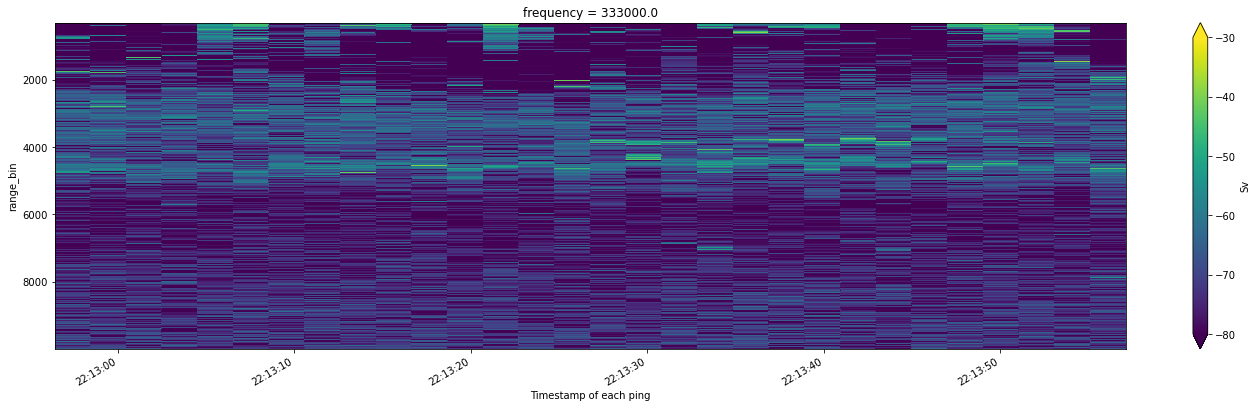

In [10]:
fig = ds_s.Sv.plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30).figure
plt.gca().invert_yaxis()

In [11]:
fig.savefig('initial_img.png')

In [12]:
ds_s['Sv']

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[-17.10310245, -22.08107285, -19.98093642, ..., -79.04223047,
        -73.33291731, -66.5757096 ],
       [-16.72995717, -21.19000748, -17.87613579, ..., -66.730753  ,
        -67.11181385, -67.6396478 ],
       [-14.27819696, -16.89551731, -15.36156324, ..., -60.8809455 ,
        -74.06718264, -66.21847555],
       ...,
       [-17.73063326, -18.46168501, -16.0302827 , ..., -66.41090009,
        -72.62850355, -73.40668722],
       [-15.94387426, -22.30148198, -17.99690114, ..., -74.90988949,
        -76.96690478, -77.06558017],
       [-16.81548799, -24.77213915, -20.58316167, ..., -70.1163601 ,
        -72.10245713, -66.97735326]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-24T22:12:57.422000128 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

## Using mean filtering to smooth the image and remove noise

C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,
C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,


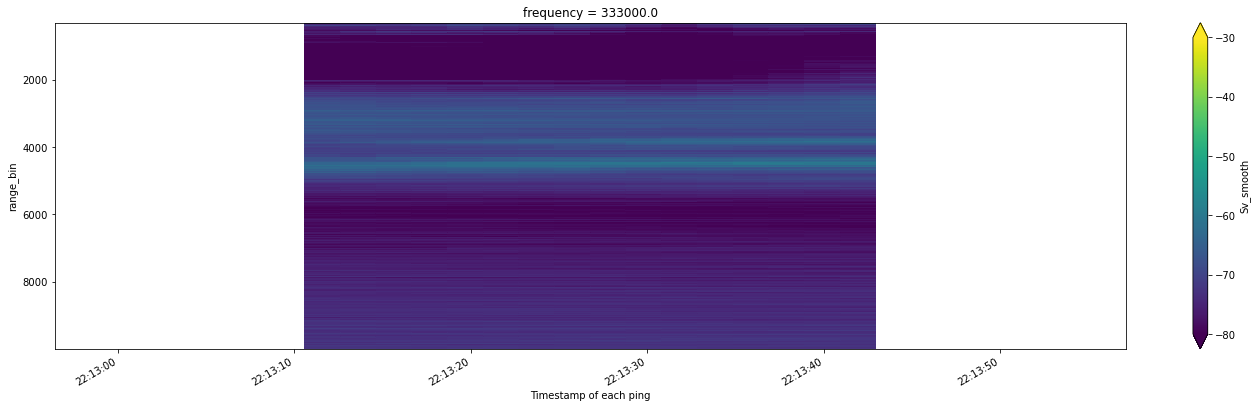

In [13]:
Sv_smooth = ds_s['Sv'].rolling(ping_time=15, center=True).mean().rolling(range_bin=5, center=True).mean()
ds_s = ds_s.assign(variables={"Sv_smooth": (('ping_time', 'range_bin'), Sv_smooth)})
(ds_s.Sv_smooth).plot(x='ping_time', size=6, aspect=4, cmap="viridis", vmin=-80, vmax=-30)
plt.gca().invert_yaxis()

# Simple thresholding using the mean

In [14]:
from skimage.filters import threshold_otsu
thresh = ds_s['Sv_smooth'].mean()# threshold_otsu(Sv_smooth.data)
thresh

<xarray.DataArray 'Sv_smooth' ()>
array(-74.50009729)
Coordinates:
    frequency  float64 3.33e+05

In [15]:
ds_s = ds_s.assign(variables={"Sv_mask": (('ping_time', 'range_bin'), (ds_s['Sv_smooth']>thresh))})
ds_s

C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,
C:\Users\mbd\anaconda3\lib\site-packages\xarray\core\variable.py:131: DeprecationWarning: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property. This will raise a TypeError in 0.19.0.
  DeprecationWarning,


<xarray.Dataset>
Dimensions:    (ping_time: 30, range_bin: 9700)
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-24T22:12:57.422000128 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999
Data variables:
    Sv         (ping_time, range_bin) float64 -17.1 -22.08 ... -72.1 -66.98
    Sv_smooth  (ping_time, range_bin) float64 nan nan nan nan ... nan nan nan
    Sv_mask    (ping_time, range_bin) bool False False False ... False False

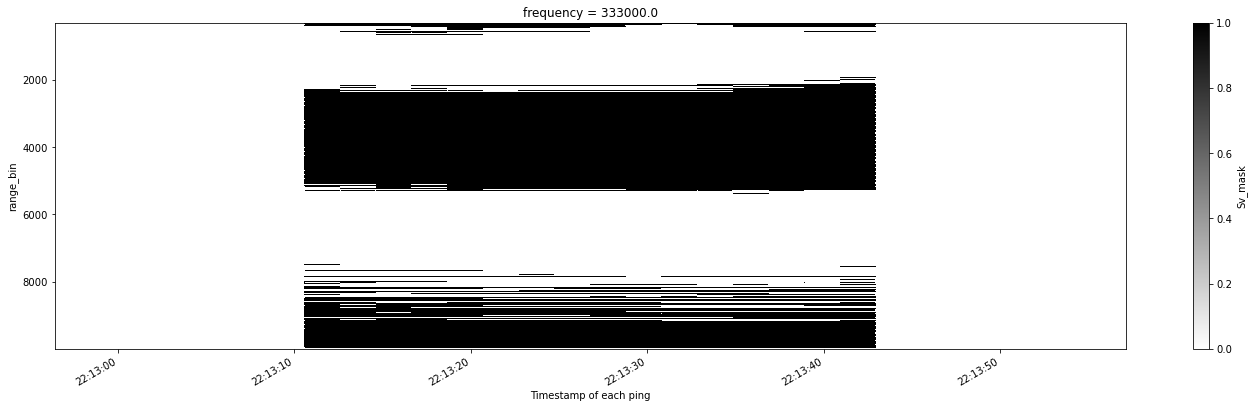

In [16]:
ds_s["Sv_mask"].plot(x='ping_time', size=6, aspect=4, cmap="binary")
plt.gca().invert_yaxis()

# Edge detection

Using canny filtering to get the edges of the layers

In [17]:
from skimage import feature
edges = feature.canny(ds_s['Sv_mask'].data, sigma=11)
ds_s = ds_s.assign(variables={"edges": (('ping_time', 'range_bin'), edges)})

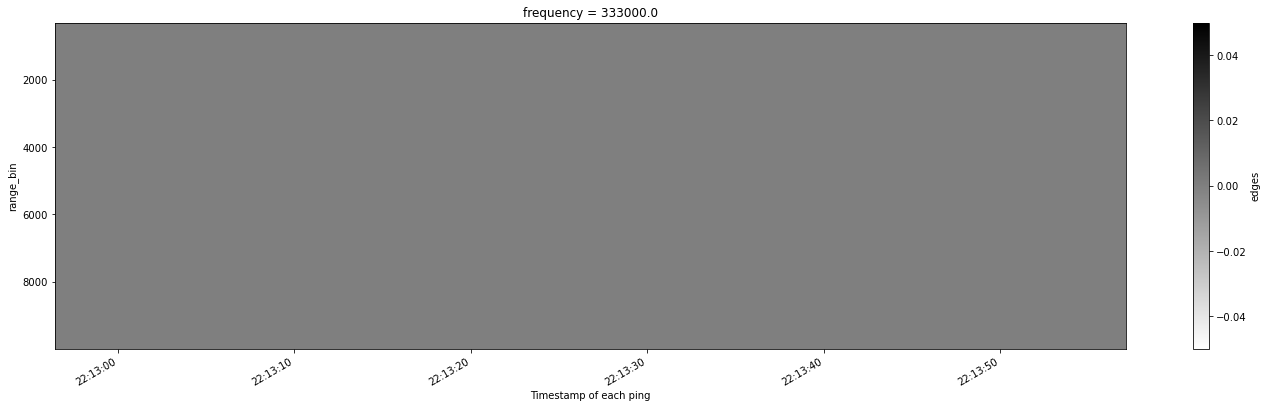

In [18]:
fig = ds_s["edges"].plot(x='ping_time', size=6, aspect=4, cmap="binary").figure
plt.gca().invert_yaxis()

In [19]:
fig.savefig('contours.png')

# Apply mask on initial image

In [20]:
filtered = ds_s['Sv'].where(ds_s['Sv_mask'])
filtered

<xarray.DataArray 'Sv' (ping_time: 30, range_bin: 9700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    frequency  float64 3.33e+05
  * ping_time  (ping_time) datetime64[ns] 2018-06-24T22:12:57.422000128 ... 2...
  * range_bin  (range_bin) int32 300 301 302 303 304 ... 9996 9997 9998 9999

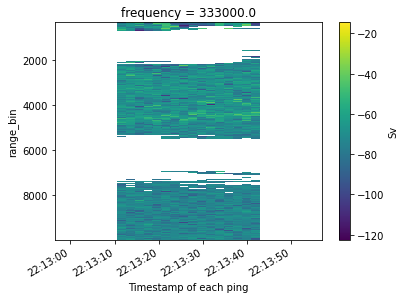

In [21]:
fig = (filtered).plot(x='ping_time', cmap="viridis").figure
plt.gca().invert_yaxis()

In [22]:
fig.savefig('mask_applied.png')

## Adding edges on the initial image

not sure how to have both overlay 

# Ressources to other methods

* Trained classifier (random forest): https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_trainable_segmentation.html#sphx-glr-auto-examples-segmentation-plot-trainable-segmentation-py

* Marching suqares algorithm: https://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html#sphx-glr-auto-examples-edges-plot-contours-py

* Blob Determinant of Hessian method: https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_doh
